# Lasso using ISTA algorithm
Below is an iteration of Lasso using the ISTA algorithm which is a variant of the subgradient descent method of finding a minimum for our loss function. 

The dataset we implement it on is a simulated dataset with 500 rows and 1000 features. We generate the target variable y based off of a sparse weight vector with only 100 values out of 1000 plus some error. What we can then observe is how lambda affects the weight vector.

1. We want to explore the relationship between the regularization parameter lambda and the number of zeros in our weight vector. Additionally we will plot the false discovery rate and true positive rate on the same curve.
2. Lambda can be either too high or too low forcing many of our regression coefficients to 0 or not cutting them harsh enough. There is going to be a sweet spot that can be seen in the FDR/TPR curve (I think this might be like a modified AUC curve except for whether weights are classified as 0 or nonzero?) which can indicate a good level of regularization resulting in a good amount of 'true features' being captured without capturing too many false features. However we never know the true values of w.


In [1]:
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np

from utils import problem


C:\Users\Wil\anaconda3\envs\cse446\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\Wil\AppData\Local\Temp\ipykernel_33340\2239033918.py:168: RuntimeWarning: invalid value encountered in long_scalars
  fdr = sum((w_hat != 0) & (w ==0) )/sum((w_hat != 0 ))


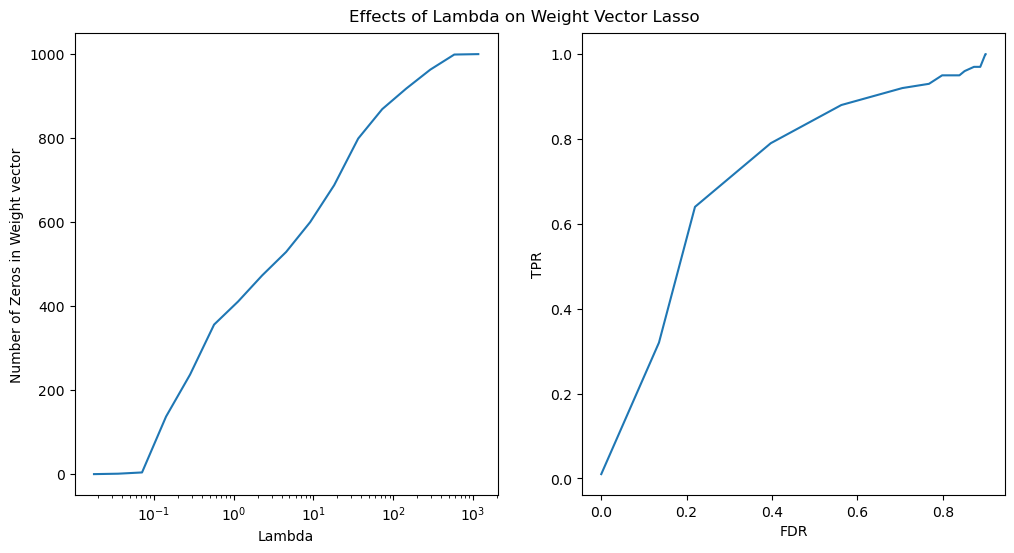

In [2]:
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np

from utils import problem

def step(
    X: np.ndarray, y: np.ndarray, weight: np.ndarray, bias: float, _lambda: float, eta: float
) -> Tuple[np.ndarray, float]:
    """Single step in ISTA algorithm.
    It should update every entry in weight, and then return an updated version of weight along with calculated bias on input weight!

    Args:
        X (np.ndarray): An (n x d) matrix, with n observations each with d features.
        y (np.ndarray): An (n, ) array, with n observations of targets.
        weight (np.ndarray): An (d,) array. Weight returned from the step before.
        bias (float): Bias returned from the step before.
        _lambda (float): Regularization constant. Determines when weight is updated to 0, and when to other values.
        eta (float): Step-size. Determines how far the ISTA iteration moves for each step.

    Returns:
        Tuple[np.ndarray, float]: Tuple with 2 entries. First represents updated weight vector, second represents bias.
    
    """
    y_pred = X @ weight
    #Calculate bias
    bias_prime = bias -  2 * eta * np.sum(y_pred + bias -y)
    #calculate weight
    weight_prime = weight - 2 * eta * (X.T @ (y_pred + bias - y))
    #update weight
    weight_prime = np.where(np.abs(weight_prime) > 2 * eta * _lambda,
                            weight_prime - np.sign(weight_prime) * 2 * eta * _lambda,
                            0)

    return(weight_prime,bias_prime)

def loss(
    X: np.ndarray, y: np.ndarray, weight: np.ndarray, bias: float, _lambda: float
) -> float:
    """L-1 (Lasso) regularized MSE loss.
           
    Args:
        X (np.ndarray): An (n x d) matrix, with n observations each with d features.
        y (np.ndarray): An (n, ) array, with n observations of targets.
        weight (np.ndarray): An (d,) array. Currently predicted weights.
        bias (float): Currently predicted bias.
        _lambda (float): Regularization constant. Should be used along with L1 norm of weight.

    Returns:
        float: value of the loss function
    """
    y_pred = X @ weight
    loss = np.sum((y_pred+bias-y)**2) + _lambda*np.sum(np.abs(weight)) #loss function for lasso 
    return(loss)


def train(
    X: np.ndarray,
    y: np.ndarray,
    _lambda: float = 0.01,
    eta: float = 0.001,
    convergence_delta: float = 1e-4,
    start_weight: np.ndarray = None,
    start_bias: float = None
) -> Tuple[np.ndarray, float]:
    """Trains a model and returns predicted weight and bias.

    Args:
        X (np.ndarray): An (n x d) matrix, with n observations each with d features.
        y (np.ndarray): An (n, ) array, with n observations of targets.
        _lambda (float): Regularization constant. Should be used for both step and loss.
        eta (float): Step size.
        convergence_delta (float, optional): Defines when to stop training algorithm.
            The smaller the value the longer algorithm will train.
            Defaults to 1e-4.
        start_weight (np.ndarray, optional): Weight for hot-starting model.
            If None, defaults to array of zeros. Defaults to None.
            It can be useful when testing for multiple values of lambda.
        start_bias (np.ndarray, optional): Bias for hot-starting model.
            If None, defaults to zero. Defaults to None.
            It can be useful when testing for multiple values of lambda.

    Returns:
        Tuple[np.ndarray, float]: A tuple with first item being array of shape (d,) representing predicted weights,
            and second item being a float representing the bias.

    """
    if start_weight is None:
        start_weight = np.zeros(X.shape[1])
    if start_bias is None:
        start_bias = 0
        
    old_w: Optional[np.ndarray] = np.copy(start_weight)
    
    #initiate weight and bias
    w,b = step(X,y, weight = start_weight, bias = start_bias, _lambda = _lambda,eta = eta)
    
    while convergence_criterion(w, old_w,bias = b, old_b = start_bias, convergence_delta = convergence_delta) == False:
        old_w = np.copy(w),
        start_bias = np.copy(b)
        w, b = step(X, y, w, b, _lambda, eta)
        delta = np.max(np.abs(w - old_w))

    return(w, b)
    


def convergence_criterion(
    weight: np.ndarray, old_w: np.ndarray, bias: float, old_b: float, convergence_delta: float
) -> bool:
    """Function determining whether weight has converged or not.
    It should calculate the maximum absolute change between weight and old_w vector, and compate it to convergence delta.

    Args:
        weight (np.ndarray): Weight from current iteration of coordinate gradient descent.
        old_w (np.ndarray): Weight from previous iteration of coordinate gradient descent.
        convergence_delta (float): Aggressiveness of the check.

    Returns:
        bool: False, if weight has not converged yet. True otherwise.
    """

    wb = np.append(bias, weight)
    old_wb = np.append(old_b, old_w)
    change = abs(wb - old_wb)
    return change.max() < convergence_delta
    
def calc_lambda(X_train,
                y_train,
                factor = 2):
    '''
    Args:
        X (np.ndarray): An (n x d) matrix, with n observations each with d features.
        y (np.ndarray): An (n, ) array, with n observations of targets.
    
    Returns:
    lambda_range (list): A list ranging from the maximum lambda (resulting in all 0
    vector for weights) to lambda >0.1. Each step is by the given factor.
    '''
    lambda_max = np.max(2*np.abs(X_train.T@(y_train - (1/X_train.shape[0]*np.sum(y_train)))))
    lambda_range = []
    while lambda_max >= 0.01:
        lambda_range.append(lambda_max)
        lambda_max = lambda_max/factor
    return lambda_range

def main():
    """
    Use all of the functions above to make plots.
    """
    ##Generate data
    X_sim = np.random.randn(500,1000) #500 x values normally distributed.
    w = np.array(list(range(1,1001))) #1-1000
    w= w/100
    w[w>1] = 0
    error = np.random.randn(500,)
    y_sim = X_sim @ w + error #create y based off of X w/ error term
    
    zeros = []
    fdr_list = []
    tpr_list = []

    lambda_range = calc_lambda(X_sim,y_sim,factor = 2)
    for reg_lambda in lambda_range:
        w_hat, b_hat = train(X_sim, y_sim, _lambda = reg_lambda, start_weight = w,start_bias = 1, eta = 0.0001)
        zeros.append(sum(w_hat ==0))
        fdr = sum((w_hat != 0) & (w ==0) )/sum((w_hat != 0 ))
        tpr = sum((w_hat !=0) & (w !=0))/100
        fdr_list.append(fdr)
        tpr_list.append(tpr)


    plt.figure(figsize = (12,6))
    plt.subplot(1,2,1)
    plt.suptitle("Effects of Lambda on Weight Vector Lasso", fontsize=12, y = 0.92)
    plt.plot(lambda_range, zeros)
    plt.xscale('log')
    plt.xlabel('Lambda')
    plt.ylabel('Number of Zeros in Weight vector')
    #plt.subplots_adjust(wspace = 0.4)
    

    plt.subplot(1,2,2)
    plt.plot(fdr_list,tpr_list)
    plt.xlabel("FDR")
    plt.ylabel("TPR")


if __name__ == "__main__":
    main()


# Lasso on real crime data

We download a dataset with many features with some sort of plausible connection to crime plus the target variable of interest (Per Capita Violent Crimes). The dataset is designed in a way that it essentially has 'too many' features. The data combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR. You can read the details [here](http://archive.ics.uci.edu/ml/datasets/communities+and+crime). 

We're going to run our above lasso solver on the dataset and analyze some of the relationships we see. Due to the nature of the data intepretation of results is extremely important and jumping to conclusions about the causation of any features may be irresponsible.

1. 3 features which may have variablility due to US historical policy changes could be: 
    - PolicBudgPerPop - Police budget can vary drastically based on location in the US. 
    - NumStreet - This is the number of homeless people on the street. Different communities have different enforcement for homeless people and areas near county jails tend to have more homeless. 
    - PctNotHSGrad - The percentage of HS graduates in a community can vary greatly based on industry in the area as well as funding for public schools.

2. 3 features which if they have a non-zero weight in the final model might be interpreted as reasons for higher levels of violent crime, but which might actually be a result rather than (or in addition to being) the cause of this violence. 
    - HousVacant - houses could be empty due to high crime 
    - PolicePerPop - police pop could be higher due to violence 
    - racepctblack - violent crime could drive out the historically more advantaged racial groups.

3. The feature with the highest coefficient was PctIlleg and the lowest was PctKids2Par. Having two parents in a relationship is a huge indicator of both financial and emotional support which could be (negatively) correlated highly with violent crime.

4. Any conclusions should be closely looked at to avoid falling into some sort of correlation = causation.


In [3]:
import pandas as pd
pd.options.display.max_columns = 999

df_train = pd.read_table("C:/Users/Wil/cse446/hw2/data/crime-data/crime-train.txt") 
df_test = pd.read_table("C:/Users/Wil/cse446/hw2/data/crime-data/crime-test.txt")

In [4]:
print(df_train.shape, df_test.shape)

(1595, 96) (399, 96)


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1595 entries, 0 to 1594
Data columns (total 96 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ViolentCrimesPerPop    1595 non-null   float64
 1   population             1595 non-null   float64
 2   householdsize          1595 non-null   float64
 3   agePct12t21            1595 non-null   float64
 4   agePct12t29            1595 non-null   float64
 5   agePct16t24            1595 non-null   float64
 6   agePct65up             1595 non-null   float64
 7   numbUrban              1595 non-null   float64
 8   pctUrban               1595 non-null   float64
 9   medIncome              1595 non-null   float64
 10  pctWWage               1595 non-null   float64
 11  pctWFarmSelf           1595 non-null   float64
 12  pctWInvInc             1595 non-null   float64
 13  pctWSocSec             1595 non-null   float64
 14  pctWPubAsst            1595 non-null   float64
 15  pctW

In [6]:
df_train.head(100)

,ViolentCrimesPerPop,population,householdsize,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumIlleg,PctIlleg,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
0,0.67,-0.45,-1.85,-1.06,0.67,0.08,-0.85,-0.34,0.68,-0.24,0.88,-0.89,-0.26,-1.27,-0.13,-0.53,-0.43,0.10,0.06,0.23,-0.26,-0.11,-0.20,-0.36,-0.28,-0.82,-0.71,-0.29,-0.46,1.32,0.86,-1.66,0.14,-0.44,2.95,1.11,2.41,2.75,-1.28,-0.90,-0.73,-0.29,-1.01,-0.25,0.02,-0.33,-0.04,-0.23,0.91,1.23,1.20,1.04,0.29,0.37,0.28,0.20,0.24,-0.23,-0.55,-0.80,-1.72,-1.29,-1.24,-1.54,0.07,1.88,-1.23,-0.38,0.36,-1.67,-0.85,-0.97,0.67,-0.43,-1.18,-0.24,-0.27,-0.25,0.34,0.04,-0.09,-0.07,-1.18,-0.69,-1.16,-0.29,-0.23,-0.02,-0.53,-1.08,-0.13,-0.66,-0.41,-0.56,1.26,-0.39
1,0.43,-0.45,-0.27,-0.22,-0.17,-0.34,-0.58,-0.50,-1.57,-0.29,0.12,-0.50,-0.59,-0.52,0.37,2.15,-0.48,-0.42,-0.42,-0.12,-0.81,-0.17,0.02,-0.36,-0.14,-0.21,0.23,-0.82,-0.02,0.45,-0.38,-0.86,0.50,-0.65,0.92,-0.14,1.27,1.12,-0.24,-0.95,-0.88,-1.07,-0.80,1.24,0.82,-0.24,0.91,-0.34,-1.14,-1.43,-1.24,-1.22,-0.68,-0.69,-0.61,-0.57,0.41,-0.50,-0.34,-0.27,-0.01,0.16,0.14,-0.72,-0.17,0.09,0.73,-0.44,0.72,-0.75,0.39,-0.71,0.11,0.85,1.00,-0.38,-0.40,-0.46,-0.35,-0.39,-0.62,-0.35,-0.06,-0.32,-0.64,-0.29,-0.23,-0.33,-0.58,0.03,0.22,-0.46,-0.50,-0.11,-0.62,-0.39
2,0.12,-0.14,1.87,0.55,0.04,0.02,-1.19,-0.03,0.68,1.05,1.81,-0.40,-0.37,-0.64,-0.53,2.03,0.68,0.05,0.17,0.58,-0.26,-0.37,0.29,-0.36,-0.89,-1.06,-0.66,-0.25,-0.17,1.20,-0.18,0.05,-0.11,-0.28,-0.66,0.09,0.01,-0.30,1.70,0.19,-0.39,0.76,0.35,2.07,1.90,-0.06,0.35,-0.12,-0.96,-0.76,-0.49,-0.60,-0.56,-0.43,-0.32,-0.31,0.11,-0.32,1.49,1.93,2.29,1.74,3.15,1.91,-0.32,-2.81,0.73,-0.44,1.29,2.22,1.82,0.19,0.11,-0.64,-0.64,-0.11,-0.23,-0.34,1.84,1.57,1.40,2.37,0.83,0.32,0.34,-0.29,-0.23,-0.11,-1.51,1.07,0.07,-0.01,-0.41,0.77,0.52,-0.39
3,0.03,-0.38,0.53,-0.28,-0.79,-0.64,-0.35,-0.34,0.46,0.66,0.88,-0.64,1.04,-0.18,-0.94,1.38,0.43,0.42,0.22,-0.06,-1.24,2.14,0.51,-0.43,-1.06,-0.31,-0.41,-0.15,-1.20,0.86,1.35,-0.35,0.14,0.10,-1.32,-0.94,-1.64,-1.55,0.14,1.48,1.40,1.03,1.39,-0.60,0.42,-0.33,-0.83,-0.34,-1.32,-1.38,-0.99,-0.81,-0.73,-0.69,-0.61,-0.57,0.41,-0.46,-0.55,-0.32,0.75,0.67,-0.18,1.66,-0.79,-1.77,0.73,-0.44,0.88,1.73,-0.76,0.62,1.01,-0.88,-0.50,0.20,0.20,0.13,0.24,-0.06,-0.17,-0.02,-1.59,0.32,-1.01,-0.29,-0.23,-0.46,0.54,0.58,-0.08,-0.61,-0.23,-0.70,-0.62,-0.39
4,0.14,-0.30,-1.12,-0.74,-0.10,-0.40,-0.30,-0.19,0.68,0.76,0.67,-0.45,0.64,-1.10,-0.76,-1.37,1.23,1.93,2.10,2.79,0.46,1.01,1.17,-0.36,-0.80,-0.87,-1.30,2.10,-1.30,0.86,-1.02,1.88,-1.67,2.52,0.16,0.77,0.70,0.47,-0.31,0.04,0.34,0.94,-0.28,-1.19,-0.55,-0.33,-0.61,0.11,-0.09,-0.05,0.15,0.22,1.35,1.35,1.58,1.65,-1.48,0.59,-0.09,-0.32,-1.02,0.23,-1.18,-0.88,0.35,1.36,-1.23,-0.38,0.62,-1.34,-0.20,-0.81,-1.05,-1.01,-0.94,3.01,3.18,3.11,1.48,1.23,1.04,1.11,-0.12,0.75,-1.53,-0.29,-0.23,2.10,-0.92,-0.25,0.52,-0.06,-0.50,1.71,-0.27,-0.39
...,...,..

Train set is 1595 rows and the test set is 399. We have a total of 96 features including the target variable of Per Capita Violent Crime.

In [7]:
X_train = df_train.drop('ViolentCrimesPerPop', axis = 1).copy()
y_train = df_train['ViolentCrimesPerPop']


def calc_lambda(X_train,
                y_train,
                factor = 2):
    '''
    Args:
        X (np.ndarray): An (n x d) matrix, with n observations each with d features.
        y (np.ndarray): An (n, ) array, with n observations of targets.
    
    Returns:
    lambda_range (list): A list ranging from the maximum lambda (resulting in all 0
    vector for weights) to lambda >0.1. Each step is by the given factor.
    '''
    lambda_max = np.max(2*np.abs(X_train.T@(y_train - (1/X_train.shape[0]*np.sum(y_train)))))
    lambda_range = []
    while lambda_max >= 0.01:
        lambda_range.append(lambda_max)
        lambda_max = lambda_max/factor
    return lambda_range

lambda_range = calc_lambda(X_train,y_train, 2)

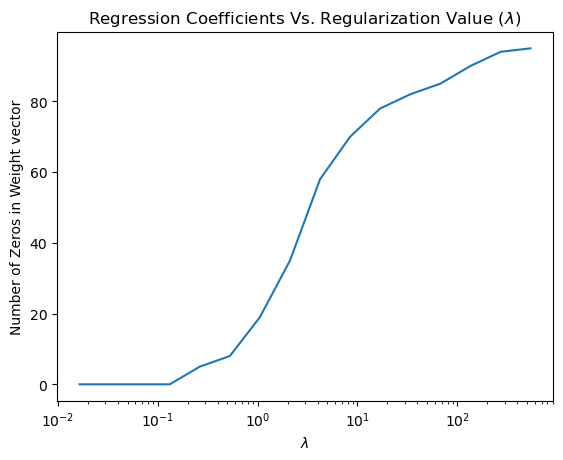

In [8]:
def zeros_plot(X,
               y,
               lambda_range,
               bias: float = 0,
               learning_rate: float = 0.00001):
    '''
    Args:
        X (np.ndarray): An (n x d) matrix, with n observations each with d features.
        y (np.ndarray): An (n, ) array, with n observations of targets.
        lambda_range (iterable): An iterable with the possible values of lambda
        bias: some initial bias.
        learning_rate: learning rate for the ISTA algorithm.
    '''
    
    zeros = [] #capture zeros in weight vector here
    weights = np.c_[np.zeros(X.shape[1])] #initialize weight as 0 
    for reg_lambda in lambda_range:
        w_hat, b_hat = train(X,y, start_weight = weights[:,-1], _lambda = reg_lambda, eta = learning_rate, convergence_delta = 0.001)
        weights = np.c_[weights,w_hat] #capture new weight and append to end of weight array
        zeros.append(sum((w_hat == 0))) #record number of zeros.

    plt.title("Regression Coefficients Vs. Regularization Value ($\lambda$)")
    plt.plot(lambda_range, zeros)
    plt.xscale('log')
    plt.xlabel('$\lambda$')
    plt.ylabel('Number of Zeros in Weight vector')
    plt.show()
    
zeros_plot(X_train, y_train, lambda_range, bias = 1, learning_rate = 0.00001)




In [9]:
import seaborn as sns
def reg_path(X,
             y,
             features: list,
             lambda_range,
             bias: float = 0,
             learning_rate: float = 0.000001
            ):
    
    #Convert the features to the index values
    query_feats = features
    feat_index = [X.columns.get_loc(col) for col in query_feats]
    
    #Add lambda to the list so we can make a dataframe
    cols = query_feats.insert(0, "Lambda")
    
    #Set weights to 0
    weights = np.c_[np.zeros(X.shape[1])]
    
    #Create a dataframe to capture the weights by feature w/ labels
    feat_weights =pd.DataFrame(columns = query_feats)
    
    for reg_lambda in lambda_range:
        #train the model and capture weights
        w_hat, b_hat = train(X,y, start_weight = weights[:,-1], _lambda = reg_lambda, start_bias = bias, eta = learning_rate, convergence_delta = 0.001)
        #append the weights to the dataframe
        temp = np.insert(w_hat[feat_index],0,reg_lambda)
        feat_weights.loc[len(feat_weights.index)] = temp
        #capture new weight and append to end of weight array
        weights = np.c_[weights,w_hat]
        
    #don't wanna loop to make plots so here's seaborn i guess.
    stacked_df = pd.melt(feat_weights,['Lambda'])
    sns.lineplot(data = stacked_df, x='Lambda', y = 'value', hue = 'variable')
    plt.xscale('log')
    plt.xlabel('$\lambda$')
    plt.ylabel('feature weight')
    plt.title('Feature Weight vs $\lambda$')
    return(feat_weights)

    
    
    
    

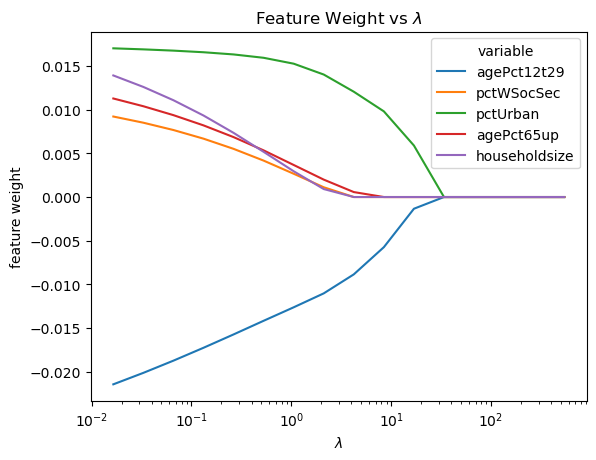

In [10]:
test_feats = ['agePct12t29','pctWSocSec',
                         'pctUrban', 'agePct65up','householdsize']
temp = reg_path(X_train,y_train, features = test_feats, lambda_range = lambda_range, learning_rate = 0.00001)

In [11]:
def mean_squared_error(a: np.ndarray, b: np.ndarray) -> float:
    """Given two arrays: a and b, both of shape (n, 1) calculate a mean squared error.

    Args:
        a (np.ndarray): Array of shape (n, 1)
        b (np.ndarray): Array of shape (n, 1)

    Returns:
        float: mean squared error between a and b.
    """
    mse = np.sum((a-b)**2/len(a))
    return(mse)

#wrote this earlier
def ValCurveLasso(X_train: np.ndarray,
                    y_train: np.ndarray,
                    X_test: np.ndarray,
                    y_test: np.ndarray,
                    param_range: list,
                    bias: float = 0,
                    learning_rate: float = 0.000001
                    ):
    """ Compute a validation curve
    Args: 
        X: data capable of being fed into model
        y: target variable capable of being predicted by model
        param_range: list of range for parameter of interest in this case lambda
        
        start_weight: start weight
        start_bias: starting bias
        learning_rate: learning rate for lass
        
    Returns:
        Nothing, but outputs a nice plot
    """
    
    train_scores = []
    test_scores = []
    
    #Set weights to 0
    weights = np.c_[np.zeros(X_train.shape[1])]
    
    
    for param in param_range:
        #train the model and capture weights
        w_hat, b_hat = train(X_train,y_train, start_weight = weights[:,-1], _lambda = param, start_bias = bias, eta = learning_rate, convergence_delta = 0.001)
        #capture new weight and append to end of weight array
        weights = np.c_[weights,w_hat]
        #fit model w/ param
        
        #get predictions
        train_preds = b_hat + (X_train @ w_hat)
        test_preds = b_hat + (X_test @ w_hat)
        #get errors.
        
            
        train_score = mean_squared_error(train_preds, y_train)
        test_score = mean_squared_error(test_preds, y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)
        print("Scores for parameter = {} calculated \n train score: {:.5} \n test score: {:.5}".format(param, train_score, test_score))
    
    plt.plot(param_range, train_scores, color='blue', marker='o', markersize=5, label='training accuracy')
    plt.plot(param_range, test_scores, color='green', linestyle='--', marker='s', markersize=5, label='test accuracy')
    
    plt.grid()
    plt.xscale('log')
    plt.legend(loc='lower right')
    plt.xlabel('Parameter C')
    plt.ylabel('MSE')
    plt.show()    

Scores for parameter = 541.4826026332289 calculated 
 train score: 0.054033 
 test score: 0.059456
Scores for parameter = 270.74130131661445 calculated 
 train score: 0.054033 
 test score: 0.059456
Scores for parameter = 135.37065065830723 calculated 
 train score: 0.031784 
 test score: 0.034364
Scores for parameter = 67.68532532915361 calculated 
 train score: 0.024085 
 test score: 0.025886
Scores for parameter = 33.84266266457681 calculated 
 train score: 0.021149 
 test score: 0.023146
Scores for parameter = 16.921331332288403 calculated 
 train score: 0.01979 
 test score: 0.022301
Scores for parameter = 8.460665666144202 calculated 
 train score: 0.019169 
 test score: 0.022047
Scores for parameter = 4.230332833072101 calculated 
 train score: 0.018823 
 test score: 0.022043
Scores for parameter = 2.1151664165360504 calculated 
 train score: 0.018505 
 test score: 0.022084
Scores for parameter = 1.0575832082680252 calculated 
 train score: 0.018277 
 test score: 0.022232
Scores

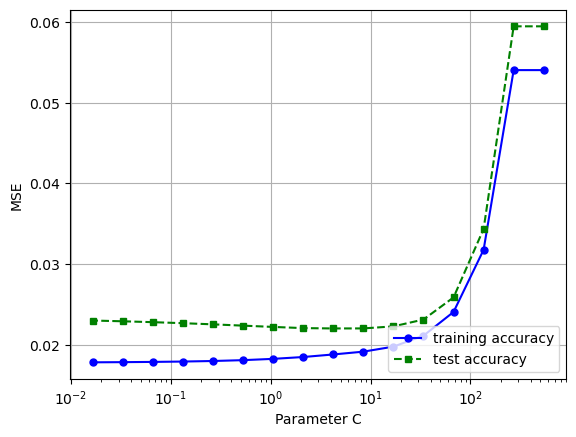

In [12]:
X_test = df_test.drop('ViolentCrimesPerPop', axis = 1).copy()
y_test = df_test['ViolentCrimesPerPop']

ValCurveLasso(X_train, y_train, X_test, y_test, lambda_range,bias = 1, learning_rate = 0.00001 )

In [13]:
# def predict(X: np.ndarray,
#             y: np.ndarray,
#             _lambda: float,
#             bias: float = 0,
#             learning_rate: float = 0.00001
#             ):
#     """ Compute a validation curve
#     Args: 
#         X: data capable of being fed into model
#         y: target variable capable of being predicted by model
#         param_range: list of range for parameter of interest in this case lambda
        
#         start_weight: start weight
#         start_bias: starting bias
#         learning_rate: learning rate for lass
        
#     Returns:
#         Nothing, but outputs a nice plot
#     """
    
#     train_scores = []
#     test_scores = []
    
#     #Set weights to 0
#     weights = np.c_[np.zeros(X_train.shape[1])]
#     w_hat, b_hat = train(X,y, start_weight = weights[:,-1], _lambda = _lambda, start_bias = bias, eta = learning_rate)
#     #capture new weight and append to end of weight array
#     weights = np.c_[weights,w_hat]
#     #fit model w/ param
#     train_preds = b_hat + (X@ w_hat)
#     return(train_preds)

In [14]:
def get_weights_30(X,
               y,
               _lambda: float = 30,
               bias: float = 0,
               learning_rate: float = 0.00001):
    '''
    Args:
        X (np.ndarray): An (n x d) matrix, with n observations each with d features.
        y (np.ndarray): An (n, ) array, with n observations of targets.
        lambda_range (iterable): An iterable with the possible values of lambda
        bias: some initial bias.
        learning_rate: learning rate for the ISTA algorithm.
    '''
    weights = np.c_[np.zeros(X.shape[1])] #initialize weight as 0 
    w_hat, b_hat = train(X,y, start_weight = weights[:,-1], _lambda = _lambda, eta = learning_rate, convergence_delta = 0.001)
    return(w_hat,b_hat)
    
w_30, b_30 = get_weights_30(X_train, y_train)

In [15]:
weights_dict = {}

weights_dict['bias'] = b_30
i = 0
for weight in X_train.columns:
    weights_dict[weight] = w_30[i]
    i+=1



In [16]:
weight_df = pd.DataFrame.from_dict(weights_dict,orient = 'index', columns = ['Values'])
weight_df[weight_df['Values'] != 0].sort_values('Values', ascending = False)

,Values
bias,0.205579
PctIlleg,0.042592
PctPersDenseHous,0.015418
HousVacant,0.010366
NumStreet,0.007794
PctLargHouseFam,0.006724
PctVacantBoarded,0.006715
NumIlleg,0.006278
FemalePctDiv,0.005259
LemasPctOfficDrugUn,0.004984


In [17]:
# def ValCurveLasso2(X_train: np.ndarray,
#                     y_train: np.ndarray,
#                     X_test: np.ndarray,
#                     y_test: np.ndarray,
#                     param_range: list,
#                     ):
#     """ Compute a validation curve
#     Args: 
#         X: data capable of being fed into model
#         y: target variable capable of being predicted by model
#         param_range: list of range for parameter of interest in this case lambda
        
#         start_weight: start weight
#         start_bias: starting bias
#         learning_rate: learning rate for lass
        
#     Returns:
#         Nothing, but outputs a nice plot
#     """
    
#     train_scores = []
#     test_scores = []
    
    
#     for param in param_range:
        
#         model = Lasso(alpha = param)#train the model and capture weights
#         model.fit(X_train,y_train)
        
#         #get predictions
#         train_preds = model.predict(X_train)
#         test_preds = model.predict(X_test)
#         #get errors.      
#         train_score = mean_squared_error(train_preds, y_train)
#         test_score = mean_squared_error(test_preds, y_test)
#         train_scores.append(train_score)
#         test_scores.append(test_score)
#         print("Scores for parameter = {} calculated \n train score: {:.5} \n test score: {:.5}".format(param, train_score, test_score))
    
#     plt.plot(param_range, train_scores, color='blue', marker='o', markersize=5, label='training accuracy')
#     plt.plot(param_range, test_scores, color='green', linestyle='--', marker='s', markersize=5, label='test accuracy')
    
#     plt.grid()
#     plt.xscale('log')
#     plt.legend(loc='lower right')
#     plt.xlabel('Parameter C')
#     plt.ylabel('MSE')
#     plt.show()    

# Logistic Regression

Below is an implementation of logistic regression with L1 regularization. The model will use stochastic gradient descent to calculate the weights. Once we have the model up and running, we will use it on the MNIST handwritten digits dataset to do a binary classification of 2s vs 7s.

1. First we derive the gradients for the classifier.


Given $J(w,b)  = \sum_1 ^n (1 + e^{y_i * (b + x_i ^T w)}) + \lambda *||w||_2^2$ 

let $z = y_i * (b + x_i ^T w)$

Then we have:

\begin{split}
\nabla_w J(w,b) & = \frac{1}{n}\sum_1^n ln (1+e^z) + \lambda ||w||_2^2 \\
 & = \frac{1}{n} \sum_1^n \cfrac{(1+e^z)'}{1+e^z} + 2\lambda w \\
 & =  \frac{1}{n} \sum_1^n \cfrac{z'e^z}{1+e^z} + 2\lambda w 
\end{split}

where we have:

\begin{split}
z & = (-y_i (b+x_i^T w))\\
 & = -y_i b - y_i x_i ^T w \\
\frac{dz}{dw} & = 0 - y_i x_i\\
\implies \frac{dz}{db} &= - y_i + 0
\end{split}



Thus:
\begin{split}
\nabla_w J(w,b) & =  \frac{1}{n} \sum_1^n \cfrac{z'e^z}{1+e^z} + 2\lambda w \\
&= \frac{1}{n} \sum_1^n \cfrac{-y_i x_i e^z}{1+e^z} + 2\lambda w \\
\nabla_b J(w,b) & = \frac{1}{n} \sum_1^n \cfrac{-y_i e^z}{1+e^z}
\end{split}

Or in expanded form we have the partial derivatives given by:

$$\frac{\partial j(w,b)}{\partial w} = \sum_{i=1}^n \frac{-y_i x_i e^{y_i * (b + x_i^T w)}}{1 + e^{y_i * (b + x_i^T w)}} + 2\lambda w$$
$$\frac{\partial j(w,b)}{\partial b} = \sum_{i=1}^n \frac{-y_ie^{y_i * (b + x_i^T w)}}{1 + e^{y_i * (b + x_i^T w)}}$$

Given $$\mu(w,b) = \frac{1}{1+ e^{y_i(b+x_i^T w)}} = \frac{1}{1+ e^{z}}$$

We can rewrite our gradients:

\begin{split}
\nabla_w J(w,b) & =  \frac{1}{n} \sum_1^n \cfrac{z'e^z}{1+e^z} + 2\lambda w  =\frac{1}{n} \sum_1^n z'\cfrac{(1+ e^z) - 1}{1+e^z} + 2\lambda w \\
&= \frac{1}{n} \sum_1^n z'\bigg(\cfrac{1+ e^z}{1+e^z} - \cfrac{1}{1+e^z}\bigg) + 2\lambda w  = \frac{1}{n} \sum_1^n z'\bigg(1 - \cfrac{1}{1+e^z}\bigg) + 2\lambda w\\
\nabla_w J(w,b) & =\frac{1}{n}  \sum_1^n -y_ix_i(1 - \mu(w,b)) + 2\lambda w
\end{split}

Similarly

$$\nabla_b J(w,b) = \frac{1}{n} \sum_1^n -y_i(1 - \mu(w,b))$$

part c


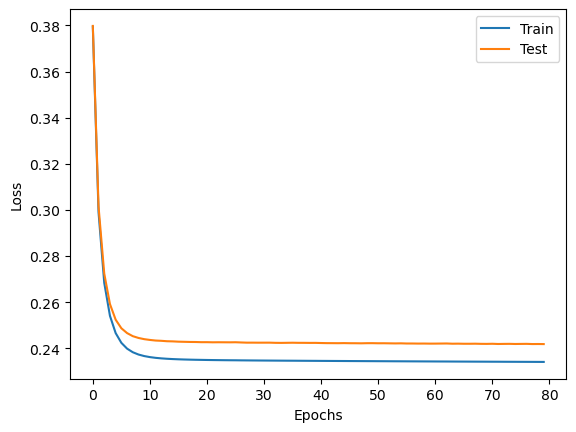

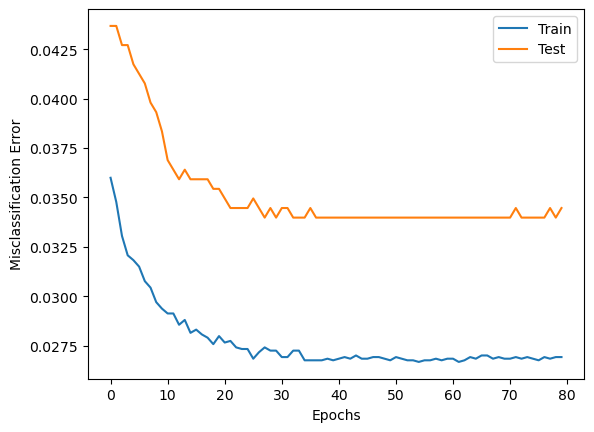

In [18]:
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np

from utils import load_dataset, problem

# When choosing your batches / Shuffling your data you should use this RNG variable, and not `np.random.choice` etc.
RNG = np.random.RandomState(seed=446)
Dataset = Tuple[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]


def load_2_7_mnist() -> Dataset:
    """
    Loads MNIST data, extracts only examples with 2, 7 as labels, and converts them into -1, 1 labels, respectively.

    Returns:
        Dataset: 2 tuples of numpy arrays, each containing examples and labels.
            First tuple is for training, while second is for testing.
            Shapes as as follows: ((n, d), (n,)), ((m, d), (m,))
    """
    (x_train, y_train), (x_test, y_test) = load_dataset("mnist")
    train_idxs = np.logical_or(y_train == 2, y_train == 7)
    test_idxs = np.logical_or(y_test == 2, y_test == 7)

    y_train_2_7 = y_train[train_idxs]
    y_train_2_7 = np.where(y_train_2_7 == 7, 1, -1)

    y_test_2_7 = y_test[test_idxs]
    y_test_2_7 = np.where(y_test_2_7 == 7, 1, -1)

    return (x_train[train_idxs], y_train_2_7), (x_test[test_idxs], y_test_2_7)


class BinaryLogReg:
    def __init__(self, _lambda: float = 1e-3):
        """Initializes the Binary Log Regression model.
        Args:
            _lambda (float, optional): Ridge Regularization coefficient. Defaults to 1e-3.
        """
        self._lambda: float = _lambda
        # Fill in with matrix with the correct shape
        self.weight: np.ndarray = None  # type: ignore
        self.bias: float = 0.0


    def mu(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Args:
            X (np.ndarray): observations represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y (np.ndarray): targets represented as `(n, )` vector.
                n is number of observations.

        Returns:
            np.ndarray: An `(n, )` vector containing mu_i for i^th element.
        """
        mu = 1/(1+np.exp(-y * (self.bias + (X @ self.weight))))
        return mu

    def loss(self, X: np.ndarray, y: np.ndarray) -> float:
        """
        Args:
            X (np.ndarray): observations represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y (np.ndarray): targets represented as `(n, )` vector.
                n is number of observations.

        Returns:
            float: Loss given X, y, self.weight, self.bias and self._lambda
        """
        y_hat = self.bias + (X @ self.weight)
        error = np.log(1 + np.exp(-y * y_hat))
        regularization = self._lambda * np.sum(np.square(self.weight))
        return(error.mean() + regularization)
                                                                                          
    def gradient_J_weight(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Calculate gradient of loss J with respect to weight.

        Args:
            X (np.ndarray): observations represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y (np.ndarray): targets represented as `(n, )` vector.
                n is number of observations.
        Returns:
            np.ndarray: An `(d, )` vector which represents gradient of loss J with respect to self.weight.
        """
        n = X.shape[0]
        grad_w = (1 / n) * np.dot(X.T, self.mu(X,y) - y) + (2 * self._lambda * self.weight)
        #return(grad_w)
        return(np.mean((self.mu(X, y) - 1) * y * X.T, axis=1) + 2 * self._lambda * self.weight)

    def gradient_J_bias(self, X: np.ndarray, y: np.ndarray) -> float:
        """Calculate gradient of loss J with respect to bias.

        Args:
            X (np.ndarray): observations represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y (np.ndarray): targets represented as `(n, )` vector.
                n is number of observations.

        Returns:
            float: A number that represents gradient of loss J with respect to self.bias.
        """
        n = X.shape[0]
        grad_b = (1 / n) * np.sum(self.mu(X,y) - y)
        #return(grad_b)
        return np.mean(y * (self.mu(X, y) - 1))
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))    
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Given X, weight and bias predict values of y.

        Args:
            X (np.ndarray): observations represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.

        Returns:
            np.ndarray: An `(n, )` array of either -1s or 1s representing guess for each observation.
        """

        pred_probit = self.__sigmoid(self.bias + (X @ self.weight))
        
        classes = pred_probit.copy()
        classes[classes>0.5] = 1
        classes[classes<0.5] = -1
                                                                                        
        return classes

    def misclassification_error(self, X: np.ndarray, y: np.ndarray) -> float:
        """Calculates misclassification error (the rate at which this model is making incorrect predictions of y).
        Note that `misclassification_error = 1 - accuracy`.

        Args:
            X (np.ndarray): observations represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y (np.ndarray): targets represented as `(n, )` vector.
                n is number of observations.

        Returns:
            float: percentage of times prediction did not match target, given an observation (i.e. misclassification error).
        """
        return(np.mean(self.predict(X) != y))

    def step(self, X: np.ndarray, y: np.ndarray, learning_rate: float = 1e-4):
        """Single step in training loop.
        It does not return anything but should update self.weight and self.bias with correct values.

        Args:
            X (np.ndarray): observations represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y (np.ndarray): targets represented as `(n, )` vector.
                n is number of observations.
            learning_rate (float, optional): Learning rate of SGD/GD algorithm.
                Defaults to 1e-4.
        """
        self.weight = self.weight - learning_rate * self.gradient_J_weight(X,y)
        self.bias = self.bias - learning_rate *self.gradient_J_bias(X,y)

    def train(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        learning_rate: float = 1e-2,
        epochs: int = 30,
        batch_size: int = 100,
    ) -> Dict[str, List[float]]:
        """
        Args:
            X_train (np.ndarray): observations in training set represented as `(n, d)` matrix.
                n is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y_train (np.ndarray): targets in training set represented as `(n, )` vector.
                n is number of observations.
            X_test (np.ndarray): observations in testing set represented as `(m, d)` matrix.
                m is number of observations, d is number of features.
                d = 784 in case of MNIST.
            y_test (np.ndarray): targets in testing set represented as `(m, )` vector.
                m is number of observations.
            learning_rate (float, optional): Learning rate of SGD/GD algorithm. Defaults to 1e-2.
            epochs (int, optional): Number of epochs (loops through the whole data) to train SGD/GD algorithm for.
                Defaults to 30.
            batch_size (int, optional): Number of observation/target pairs to use for a single update.
                Defaults to 100.

        Returns:
            Dict[str, List[float]]: Dictionary containing 4 keys, each pointing to a list/numpy array of length `epochs`:
            {
                "training_losses": [<Loss at the end of each epoch on training set>],
                "training_errors": [<Misclassification error at the end of each epoch on training set>],
                "testing_losses": [<Same as above but for testing set>],
                "testing_errors": [<Same as above but for testing set>],
            }

        Note:
            - When shuffling batches/randomly choosing batches makes sure you are using RNG variable defined on the top of the file.
        """
        num_batches = int(np.ceil(len(X_train) // batch_size))
        result: Dict[str, List[float]] = {
            "train_losses": [],  # You should append to these lists
            "train_errors": [],
            "test_losses": [],
            "test_errors": [],
        }
        # initialize weight
        n, d = X_train.shape
        if self.weight is None:
            self.weight = np.zeros(d)

        for i in range(epochs):
            if (batch_size < n):
                shuffle = RNG.permutation(n)
                X_train = X_train[shuffle]
                y_train = y_train[shuffle]
            for j in range(num_batches):
                batch_start = j * batch_size
                batch_end = min(batch_start + batch_size, n)
                self.step(X_train[batch_start:batch_end], y_train[batch_start:batch_end], learning_rate)
            result["train_losses"].append(self.loss(X_train, y_train))
            result["test_losses"].append(self.loss(X_test, y_test))
            result["train_errors"].append(self.misclassification_error(X_train, y_train))
            result["test_errors"].append(self.misclassification_error(X_test, y_test))

        return result
            
def make_plots(history: Dict[str, List[float]]):
    # Plot losses
    plt.plot(history["train_losses"], label="Train")
    plt.plot(history["test_losses"], label="Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot error
    plt.plot(history["train_errors"], label="Train")
    plt.plot(history["test_errors"], label="Test")
    plt.xlabel("Epochs")
    plt.ylabel("Misclassification Error")
    plt.legend()
    plt.show()


    #Can produce different plots here.
if __name__ == "__main__":
    model = BinaryLogReg()
    (x_train, y_train), (x_test, y_test) = load_2_7_mnist()

    n, d = x_train.shape
    model._lambda = 0.1

    # PLOT 1 no stochastic batch size = n
    # print('part b')
    # learning_rate = 0.3
    # epochs = 100
    # batch_size = n
    # history = model.train(x_train, y_train, x_test, y_test, learning_rate, epochs, batch_size)
    # make_plots(history)

    # plot 2  batch size = 1
    print('part c')
    learning_rate = 0.00003
    epochs = 80
    batch_size = 1
    history = model.train(x_train, y_train, x_test, y_test, learning_rate, epochs, batch_size)
    make_plots(history)

    # plot 3 batch size = 100
    # print('part d')
    # learning_rate = 0.003
    # epochs = 100
    # batch_size = 100
    # history = model.train(x_train, y_train, x_test, y_test, learning_rate, epochs, batch_size)
    # make_plots(history)
